In [32]:
!pip install --quiet norse 
!pip install --quiet torch
!pip install --quiet torchvision

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
% cd "/content/drive/MyDrive/Norse SNN/Speach/"
% ls

/content/drive/MyDrive/Norse SNN/Speach
 checkpoints/
'CNN Russian_Speach_Digit_0-9.ipynb'
'code 3conv zeros.ipynb'
'code Russian digit 98 acc check point.ipynb'
'code Speech command comm.ipynb'
'code Speech command digits.ipynb'
'code Speech TIMIT phoneme.ipynb'
'code Speech TIMIT words.ipynb'
 data/
 NB/
'Quant code Speech TIMIT words.ipynb'
'Копия code 3conv zeros.ipynb'
'Копия code.ipynb'


In [35]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data


import torchvision

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
import importlib
from tqdm.notebook import tqdm, trange

#norse
import norse
from norse.torch import LIFCell, LILinearCell  
from norse.torch.module import LILinearCell, LIFParameters, LIState, LIFFeedForwardState, SequentialState, LICell

from norse.torch.module.encode  import ConstantCurrentLIFEncoder, PoissonEncoder, SpikeLatencyLIFEncoder


from typing import NamedTuple


In [36]:
BATCH_SIZE = 32
T = 48
LR = 0.001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('select device:', DEVICE)

select device: cuda


## Dataset


### transforms

In [37]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

### CIFAR10

In [38]:
def load_CIFAR10(path="./data", BATCHSIZE = BATCH_SIZE, transformtrain=transform_train, transformtest=transform_test):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(
                root=path, train=True, download=True, transform=transformtrain
            ),
        batch_size=BATCHSIZE,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(
                root=path, train=False, transform=transform_test
            ),
        batch_size=BATCHSIZE,
        shuffle=False
    )
    return train_loader, test_loader

In [39]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

def print_CIFAR10(train_loader):

    images, labels = iter(train_loader).next()


    images1, labels1 = images[:3], labels[:3]
    images2, labels2 = images[3:6], labels[3:6]

    fig, axes = plt.subplots(1, len(images1), figsize=(12,12))
    for idx, image in enumerate(images1):
        axes[idx].imshow(convert_to_imshow_format(image))
        axes[idx].set_title(classes[labels1[idx]])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

    fig, axes = plt.subplots(1, len(images2), figsize=(12,12))
    for idx, image in enumerate(images2):
        axes[idx].imshow(convert_to_imshow_format(image))
        axes[idx].set_title(classes[labels2[idx]])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])   


### EMNIST

In [40]:
def load_EMNIST(path="./data", split = 'mnist', BATCHSIZE = BATCH_SIZE, transformtrain=transform_train, transformtest=transform_test):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.EMNIST(
            root=path, train=True, download=True, transform=transform_train,
            split = split
        ),
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.EMNIST(
            root=path, train=False, transform=transform_test,
            split = split
        ),
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    return train_loader, test_loader

In [41]:
def print_EMNIST(train_loader):
    images, labels = iter(train_loader).next()
    images1, labels1 = images[:10], labels[:10]
    grid_img = torchvision.utils.make_grid(images1, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))

### Data loader

In [42]:
def load_split_train_test(datadir = "./data/Russian_Speach_Digit_0-9 (spec, low)", valid_size = .2, batch_size=BATCH_SIZE):
    print('batch_size', batch_size)
    train_transforms = transforms.Compose([transforms.Resize(28),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.13,), (0.3,)),
                                           #transforms.Lambda(lambda d: torch.reshape(d[1,:,:], (1, d.shape[1], d.shape[2]) ))
                                          ])
    test_transforms = transforms.Compose([transforms.Resize(28),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.13,), (0.3,)),
                                          #transforms.Lambda(lambda d: torch.reshape(d[1,:,:], (1, d.shape[1], d.shape[2]) ))
                                         ])

    train_data = torchvision.datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = torchvision.datasets.ImageFolder(datadir,
                    transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)


    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
                   
    return trainloader, testloader

### Info

In [43]:
dtype = torch.float16

train_loader, test_loader = load_split_train_test()
img, _ = train_loader.dataset[0]

classes = train_loader.dataset.classes
print('classes:', classes)
print('train loader size:', len(train_loader))

batch_size 32
classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
train loader size: 250


9


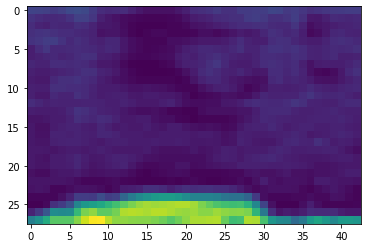

In [44]:
print(train_loader.dataset[9021][1])
plt.imshow(train_loader.dataset[9021][0][0])

In [45]:
#print_CIFAR10(train_loader)

## Encode

In [46]:
def plot_spikes_2d(fig, z):
    T = z.shape[0]
    C = z.shape[1]

    fig.set_size_inches(10,8)
    for c in range(C):
        ax = fig.add_subplot(1, C, c+1, projection='3d')
        s = z[:,c].detach().to_sparse().coalesce()

        ax.invert_yaxis()
        ax.invert_zaxis()
        ax.set_xlim([0,T])
        ax.set_xlabel('time [ms]')
        ax.set_ylabel('spectrogram time')
        ax.set_zlabel('spectrogram Hz')
        ax.scatter(s.indices()[0], s.indices()[2], s.indices()[1], s=1.0, c=s.values())

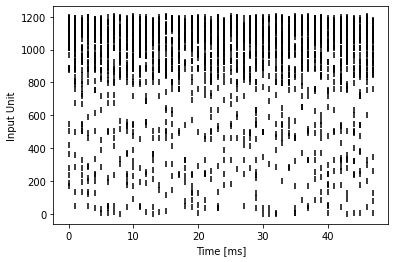

In [47]:
example_encoder = PoissonEncoder(T)


example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

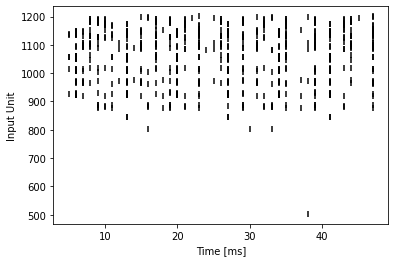

In [48]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

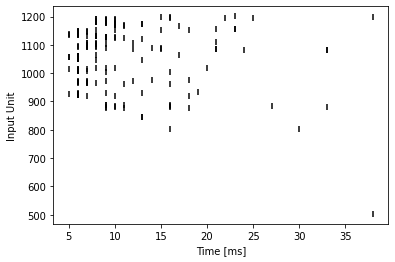

In [49]:
example_encoder = SpikeLatencyLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

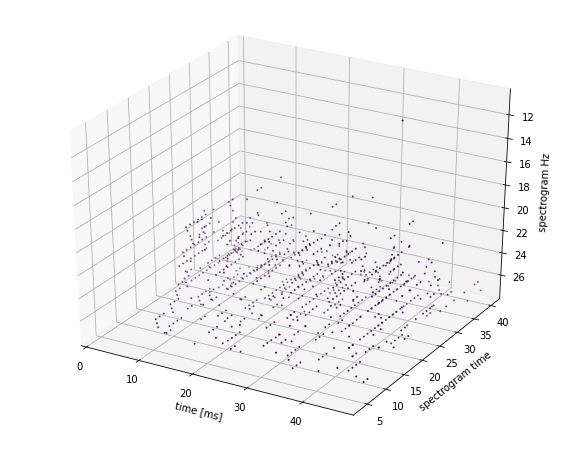

In [50]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0].reshape((1, img.shape[1], img.shape[2])))


fig = plt.figure()

plot_spikes_2d(fig, example_input)

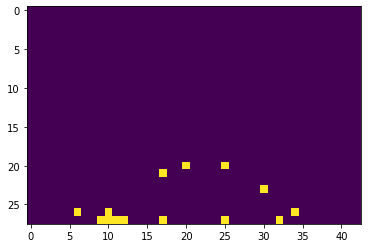

In [51]:
plt.imshow(example_input[32][0])

## Convolutional Networks


### CNNs

In [52]:
class CNN(nn.Module):

  def __init__(self): 
         super(CNN, self).__init__() 
         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

         self.convlayer1 = nn.Sequential( 
                              nn.Conv2d(32, 64, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.convlayer2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.fclayer1 = nn.Sequential( 
                              nn.Linear(6720, 4096) , 
                              nn.Dropout(0.2) 
                              ) 
         
         self.fclayer2 = nn.Sequential( 
                              nn.Linear(4096, 2048) , 
                              nn.Dropout(0.2) 
                              ) 
            

         self.out = nn.Linear(2048, 10)

  def forward(self, x): 
         out = self.conv1(x) 
         out = self.convlayer1(out) 
         out = self.convlayer2(out) 
         out = out.reshape(out.size(0), -1) 
         #print(out.shape)

         out = self.fclayer1(out) 
         out = self.fclayer2(out) 

         return self.out(out)


In [53]:
class CNN2(nn.Module):

  def __init__(self): 
         super(CNN2, self).__init__() 


         self.conv1 = nn.Sequential( 
                              nn.Conv2d(3, 64, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         
         self.conv2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.conv3 = nn.Sequential( 
                              nn.Conv2d(96, 128, kernel_size=3), 
                              nn.ReLU(),
                              #nn.MaxPool2d(kernel_size=2)
                              ) 
         

         self.drop_out = nn.Dropout() 

         self.fclayer1 = nn.Linear(2048, 768)


        

         self.out = nn.Linear(768, 10)

  def forward(self, x): 
         out = self.conv1(x) 

         out = self.conv2(out) 

         out = self.conv3(out) 

         out = out.reshape(out.size(0), -1) 
         out = self.drop_out(out) 
         #print(out.shape)

         out = self.fclayer1(out) 


         return self.out(out)


### SNNs

In [54]:
class Model(nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn     = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [55]:
class SCNN(nn.Module):
    def __init__(
        self,  num_channels=1, classes = 10, 
        input_size=(28, 28), kernel_size = 3, 
        method="super", alpha=100, 
    ):
        super(SCNN, self).__init__()

        #### -- ####
        self.lif_param = LIFParameters(method=method, alpha=alpha)
        self.features =  torch.tensor(input_size).int()
        self.max_pool2d = torch.nn.MaxPool2d(2)

        self.features2 = None


        print(self.features)

        #### Conv2D ####
        self.conv1 = torch.nn.Conv2d(num_channels, 64, kernel_size, 1)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features1 = self.features
        print(self.features)


        self.conv2 = torch.nn.Conv2d(self.conv1.out_channels, 96, kernel_size, 1)
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features2 = self.features
        print(self.features)


        #### FC ####
        self.features = self.features[0] * self.features[1] * self.conv2.out_channels

        self.fc1 = torch.nn.Linear(self.features, int(self.features/4))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #### Out ####
        self.out = LILinearCell(int(self.features/4), 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        
        # specify the initial states
        s0 = s1 = s2 = s3 = s4 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )


        self.z_tmp_1 = torch.zeros(
            seq_length, batch_size, self.conv1.out_channels, self.features1[0], self.features1[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_2 = torch.zeros(
            seq_length, batch_size, self.conv2.out_channels, self.features2[0], self.features2[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_fc = torch.zeros(
            seq_length, batch_size, self.fc1.out_features, device=x.device, dtype=x.dtype
        )         
        for ts in range(seq_length):

            z, s0 = self.lif0(10*self.conv1(x[ts, :]), s0)
            z = self.max_pool2d(z)

            self.z_tmp_1[ts, ...] = z 

            z, s1 = self.lif1(self.conv2(z), s1)
            z = self.max_pool2d(z)

            self.z_tmp_2[ts, ...] = z


            z = z.view(-1, self.features)


            z, s3 = self.lif2(self.fc1(z), s3)

            self.z_tmp_fc[ts, ...] = z



            voltages[ts, :, :], so = self.out(z, so)


        return voltages

In [56]:
def decode(x):
    x, _ = torch.max(x, 0)
    return F.log_softmax(x)

## Train test

In [57]:
def evalute(model, test_loader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for img, target in tqdm(test_loader):
          
            out = model(img.to(DEVICE))
            
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)


    return 100*correct / total

In [58]:
def train(model, train_loader, optimizer):
      model.train()
      for img, target in tqdm(train_loader):
          img, target = img.to(DEVICE), target.to(DEVICE)

          optimizer.zero_grad()

          out = model(img)

          loss = F.nll_loss(out, target)
          
          loss.backward()

          optimizer.step()

      return loss.item() 

In [59]:
def train_test_loop(model, train_loader, test_loader, opt = 'SGD', EPOCH = 1, lr = 0.01, momentum=0.9 ):
    print('Train model')
    
    if opt == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
    elif opt == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
      print('Unknown optim', opt)


    model.to(DEVICE)

    best_acc = evalute(model, test_loader)
    print('\nAccuracy now: ', best_acc)
    
    for epoch in range(1,EPOCH+1):
        print("\nEpoch %d/%d"%(epoch, EPOCH))

        loss = train(model, train_loader, optimizer)
        
        acc = evalute(model, test_loader)
        
        print("Accuracy: ", acc)

        if best_acc < acc:
          print('Save', best_acc,'-->', acc)
          torch.save( model, './checkpoints/snn rus digits.pth')
          best_acc = acc
          
        print()

    model = torch.load('./checkpoints/snn rus digits.pth')
    print("\nBest Acc=%.4f"%(best_acc))

## Train test loop

In [60]:
model = Model(
    encoder= ConstantCurrentLIFEncoder(T),
    snn=SCNN(num_channels = img.shape[0], classes = len(classes), input_size = img[0].shape),
    decoder=decode
).to(DEVICE)

model

tensor([28, 43], dtype=torch.int32)
tensor([13, 20], dtype=torch.int16)
tensor([5, 9], dtype=torch.int16)


Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SCNN(
    (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (lif0): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (conv2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (lif1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (fc1): Linear(in_features=4320, out_features=1080, bias=True)
    (lif2): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (out): LILinearCell()
  )
)

In [61]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 10, lr = LR/4)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  10.531594784353059

Epoch 1/10



Accuracy:  93.78134403209629
Save 10.531594784353059 --> 93.78134403209629


Epoch 2/10



Accuracy:  96.58976930792377
Save 93.78134403209629 --> 96.58976930792377


Epoch 3/10



Accuracy:  97.89368104312939
Save 96.58976930792377 --> 97.89368104312939


Epoch 4/10



Accuracy:  97.79338014042126


Epoch 5/10



Accuracy:  98.29488465396189
Save 97.89368104312939 --> 98.29488465396189


Epoch 6/10



Accuracy:  98.69608826479438
Save 98.29488465396189 --> 98.69608826479438


Epoch 7/10



Accuracy:  96.94082246740221


Epoch 8/10



Accuracy:  98.84653961885657
Save 98.69608826479438 --> 98.84653961885657


Epoch 9/10



Accuracy:  99.24774322968906
Save 98.84653961885657 --> 99.24774322968906


Epoch 10/10



Accuracy:  99.44834503510532
Save 99.24774322968906 --> 99.44834503510532


Best Acc=99.4483


In [62]:
evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


99.44834503510532

In [63]:
evalute(model, train_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


99.88716148445336

In [64]:
 torch.save( model, './checkpoints/snn rus digits 99_4.pth')